In [1]:
import scanpy as sc
import pandas as pd
import diffxpy.api as de
import numpy as np
import patsy
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
import upsetplot as usp
from matplotlib import rcParams
from diffxpy.testing.det import DifferentialExpressionTestWald
import matplotlib.cm as cm
import matplotlib as mpl
from sklearn.preprocessing import minmax_scale
from anndata import AnnData
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy import sparse
from diffxpy.testing.det import DifferentialExpressionTestWald

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/data_exploration/')
import helper_diffxpy as hde
import importlib
importlib.reload(hde)
import helper_diffxpy as hde
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as h
import importlib
importlib.reload(h)
import helper as h

In [3]:
# Set Path variables to call when needed
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_full='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_de='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/de/de_sexaging_covarSample/'

In [4]:
# Load the needed data 
adata_b_rn=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')

In [5]:
adata_b_rn

AnnData object with n_obs × n_vars = 102143 × 30672
    obs: 'study_sample', 'study', 'file', 'reference', 'size_factors_sample', 'S_score', 'G2M_score', 'phase', 'phase_cyclone', 's_cyclone', 'g2m_cyclone', 'g1_cyclone', 'sex', 'pre_cell_type', 'ins_score', 'ins_high', 'gcg_score', 'gcg_high', 'sst_score', 'sst_high', 'ppy_score', 'ppy_high', 'cell_filtering', 'age', 'strain', 'tissue', 'technique', 'internal_id', 'batch', 'study_sample_design', 'cell_type', 'cell_type_multiplet', 'cell_subtype', 'cell_subtype_multiplet', 'design', 'cell_type_integrated', 'cell_type_integrated_v1', 'gcg_score_scaled', 'ins_score_scaled', 'ppy_score_scaled', 'sst_score_scaled', 'n_counts', 'n_genes', 'mt_frac', 'emptyDrops_LogProb', 'emptyDrops_LogProb_scaled', 'leiden_r0.4', 'leiden_r0.7', 'leiden_r1', 'leiden_r1.5', 'leiden_r2', 'size_factors_integrated', 'de_aging_dpt_pseudotime', 'de_diseased_healthy_diseased_axis', 'de_diseased_healthy_diseased_cl_axis', 'de_diseased_healthy_diseased_cl_axis_sub',

## Prepare data

Subset data

In [5]:
# Samples which should be analysed 
studies=['Fltp_P16']
samples=adata_b_rn.obs.query('study in @studies').study_sample.unique().tolist()
print('N samples to use',len(samples))
print(samples)

N samples to use 3
['Fltp_P16_145_mGFP', 'Fltp_P16_146_mRFP', 'Fltp_P16_147_mTmG']


In [6]:
# Subset 
# Samples
adata_b_rn_sub=adata_b_rn[adata_b_rn.obs.study_sample.isin(samples),:].copy()
# Clusters
adata_b_rn_sub=adata_b_rn_sub[ ~adata_b_rn_sub.obs['leiden_r1.5'].isin(['19','20']),:].copy()
print(adata_b_rn_sub.shape)
print(adata_b_rn_sub.obs.study_sample_design.unique().tolist())
print(adata_b_rn_sub.obs['leiden_r1.5'].unique().tolist())

(7395, 30672)
['Fltp_P16_145_mGFP_mGFP', 'Fltp_P16_146_mRFP_mRFP', 'Fltp_P16_147_mTmG_mTmG']
['14', '10', '15', '17', '13', '5', '1', '3', '2', '16', '7', '8', '9', '12', '11', '18', '22', '21', '6', '4']


Plot data

In [7]:
# Compute a neighborhood graph of observations and the umap
sc.pp.neighbors(adata_b_rn_sub,n_pcs=0,use_rep='X_integrated')
sc.tl.umap(adata_b_rn_sub)

Trying to set attribute `._uns` of view, copying.


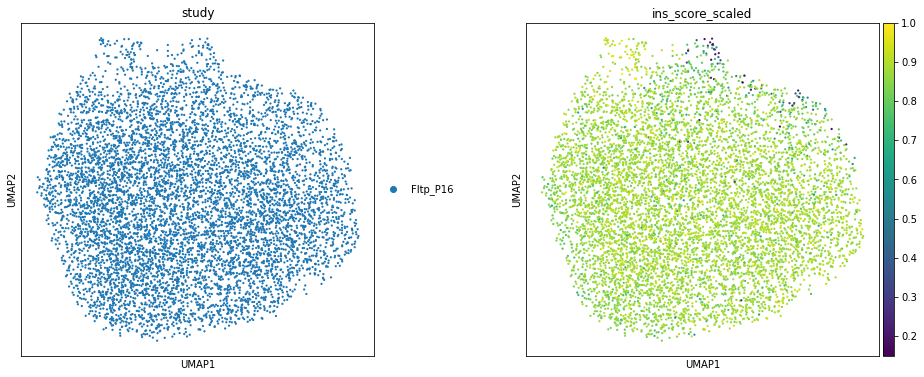

In [8]:
# Plot umap for adata.obs study and ins_score_scaled
rcParams['figure.figsize']=(6,6)
random_indices=np.random.permutation(list(range(adata_b_rn_sub.shape[0])))
sc.pl.umap(adata_b_rn_sub[random_indices,:],
           color=['study','ins_score_scaled'],s=20,sort_order=False,wspace=0.3)

Trying to set attribute `._uns` of view, copying.


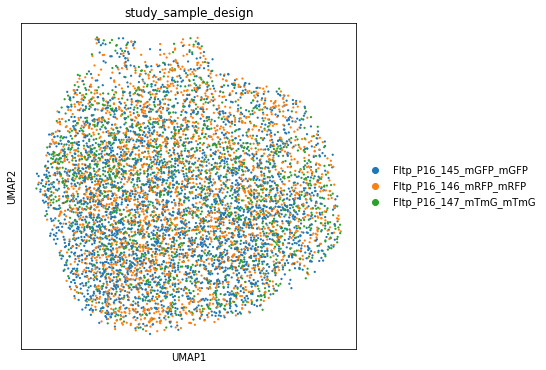

In [9]:
# Plot umap for adata.obs study_sample_design, to see the different samples
rcParams['figure.figsize']=(6,6)
random_indices=np.random.permutation(list(range(adata_b_rn_sub.shape[0])))
sc.pl.umap(adata_b_rn_sub[random_indices,:],
           color=['study_sample_design'],s=20,sort_order=False,wspace=0.3)

## DE test

DE data

In [10]:
# Get raw expression data for DE testing, subsetting by cells
adata_b_raw_sub=sc.read( path_data+'data_integrated_analysed_beta_v1s1.h5ad'
    ).raw.to_adata()[ adata_b_rn_sub.obs_names,:].copy()
print(adata_b_raw_sub.shape)

(7395, 30672)


In [11]:
# Add the new obs 'sex_female' to adata with female = 1 and male = 0
adata_b_rn_sub.obs['sex_num']=adata_b_rn_sub.obs.sex.replace(['female', 'male'], [1, 0])

In [12]:
# Add needed obs for DE
adata_b_raw_sub.obs=pd.concat( [adata_b_rn_sub.obs['size_factors_integrated'], 
                                adata_b_rn_sub.obs['sex'], 
                                adata_b_rn_sub.obs['age'],
                                adata_b_rn_sub.obs['sex_num'],
                                adata_b_raw_sub.obs['file']],axis=1)

Expression filtering

In [13]:
# Set the minimun cell ratio:
min_cells_ratio=0.05

In [14]:
# prepare adata
# Data for testing
adata=adata_b_raw_sub.copy()
# Select expressed genes in partition
min_cells=adata.shape[0]*min_cells_ratio
print('Min cells: %.1f'% min_cells)
expressed=np.array((adata.X.todense()!=0).sum(axis=0)>=min_cells)[0]
adata=adata[:,expressed]
print('Data after expression filtering:',adata.shape)

Min cells: 369.8
Data after expression filtering: (7395, 9568)


Ambient removal

In [15]:
# Remove all ambient genes (from all studies)
ambient_nobeta=pickle.load(open('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/ambient/ambient_nonbeta.pkl'
    ,'rb'))['ambient_nonbeta']
print('N ambient genes:',len(ambient_nobeta))
adata=adata[:,[g for g in adata.var_names 
                                   if g not in ambient_nobeta]]
print('Data after ambient filtering:',adata.shape)

N ambient genes: 367
Data after ambient filtering: (7395, 9313)


Design-Matrix

In [16]:
# Create a design Matrix

dmat_loc=pd.DataFrame(index=adata.obs_names)
dmat_loc['Intercept']=1

# process of interest
process='sex_num'
dmat_loc[process]=adata.obs[process]

# Add files, these are the samples 
# 3 samples, one is in intercept
# Samples: ['Fltp_P16_145_mGFP', 'Fltp_P16_146_mRFP', 'Fltp_P16_147_mTmG']
dmat_loc['146_mRFP']=adata_b_rn_sub.obs.file.replace(['146_mRFP', '145_mGFP', '147_mTmG'], [1, 0, 0])
dmat_loc['147_mTmG']=adata_b_rn_sub.obs.file.replace(['147_mTmG', '145_mGFP', '146_mRFP'], [1, 0, 0])
    
dmat_loc.fillna(0,inplace=True)
dmat_loc=dmat_loc.astype('float')

print('dmat_loc')
display(dmat_loc)

dmat_scale=pd.DataFrame(dmat_loc['Intercept'])
constraints_scale=None
constraints_loc=None

sex_female=process

dmat_loc


,Intercept,sex_num,146_mRFP,147_mTmG
AAACCTGGTAAGAGAG-1-145_mGFP-Fltp_P16,1.0,1.0,0.0,0.0
AAACCTGGTAAGGGAA-1-145_mGFP-Fltp_P16,1.0,1.0,0.0,0.0
AAACCTGGTACCGAGA-1-145_mGFP-Fltp_P16,1.0,1.0,0.0,0.0
AAACCTGGTTCCCGAG-1-145_mGFP-Fltp_P16,1.0,0.0,0.0,0.0
AAACGGGAGACAGAGA-1-145_mGFP-Fltp_P16,1.0,1.0,0.0,0.0
...,...,...,...,...
TTTGTCAAGAGACTTA-1-147_mTmG-Fltp_P16,1.0,0.0,0.0,1.0
TTTGTCAAGATATGCA-1-147_mTmG-Fltp_P16,1.0,1.0,0.0,1.0
TTTGTCAAGCCGTCGT-1-147_mTmG-Fltp_P16,1.0,0.0,0.0,1.0
TTTGTCACATCCTAGA-1-147_mTmG-Fltp_P16,1.0,0.0,0.0,1.0


In [18]:
# Create dense adata, so that the Waldtest can work
if sparse.issparse(adata.X):
        new_adata = sc.AnnData(X=adata.X.A, obs=adata.obs.copy(deep=True), var=adata.var.copy(deep=True), uns=adata.uns.copy(), obsm=adata.obsm.copy())

In [ ]:
# Perform the Wald test
if True:
    # Compute result
    result=de.test.wald(
        data=new_adata,
        coef_to_test=sex_female,
        dmat_loc=dmat_loc,
        dmat_scale=dmat_scale,
        # Use integarted sf
        size_factors=new_adata.obs.size_factors_integrated,
        )

    # Add design info to result
    result.dmat_loc=dmat_loc
    result.dmat_scale=dmat_scale
    result.coef_loc_totest_name=sex_female

    # save result
    pickle.dump(result, 
        open(path_de+'maleFemale_Fltp_P16_'+str(min_cells_ratio)+'.pkl', 
                     "wb" ))

## Analyse DE data

In [19]:
# Loada data
result=pickle.load(
    open(path_de+'maleFemale_Fltp_P16_'+str(min_cells_ratio)+'.pkl','rb'))

summary=result.summary()
summary.index=summary.gene

### DE result vs gene characteristics

In [20]:
# Calculate empirical_log2fc
c2=adata_b_rn_sub.obs_names[adata_b_rn_sub.obs['sex_num']==1]
c1=adata_b_rn_sub.obs_names[adata_b_rn_sub.obs['sex_num']==0]
result.empirical_log2fc=pd.Series(np.asarray(np.log2(
     (adata_b_rn_sub[c2,summary.gene].X/
          adata_b_rn_sub[c2,summary.gene].obs['size_factors_integrated'].values.reshape(-1,1)).mean(axis=0)/
     (adata_b_rn_sub[c1,summary.gene].X/
          adata_b_rn_sub[c1,summary.gene].obs['size_factors_integrated'].values.reshape(-1,1)).mean(axis=0)
    )).ravel(), index=summary.gene).replace(np.inf,np.nan)

In [21]:
# calculate n_cells and then calculate mean_expr_in_expr_cells
n_cells=pd.Series(np.asarray((adata_b_rn_sub.X.todense()!=0).sum(axis=0)).ravel(),
                  index=adata_b_rn_sub.var_names)
mean_expr_in_expr_cells=pd.Series(np.asarray(
    adata_b_rn_sub[result.dmat_loc.index].X.sum(axis=0)
          ).ravel(),index=adata_b_rn_sub.var_names)/n_cells

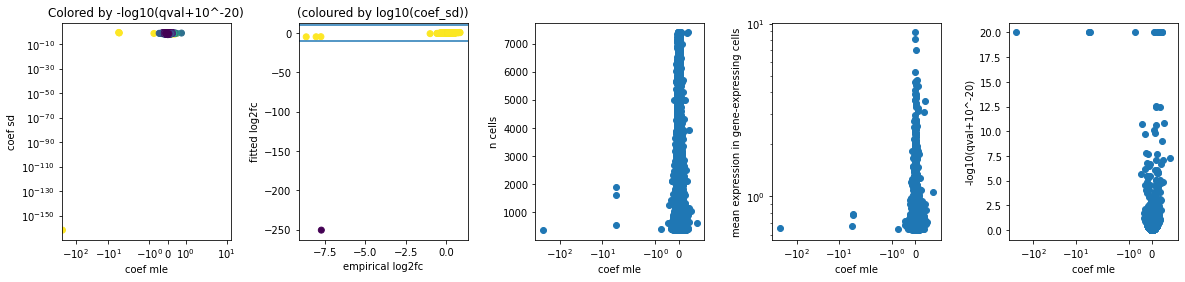

Min coef_sd: 2.2227587494850775e-162


In [22]:
# Plot diagramms for coef sd over coef mle,  fitted log2fc over empirical log3fc, 
# n cells over coef mle,  mean expr in gene_epxr cells over coef mle,  
# -log10(qval+10^-20) over coef mle,
# to see if we need to filter the results/summary for to small coef sd

fig,ax=plt.subplots(1,5,figsize=(20,4))
plt.subplots_adjust(wspace=0.4)

ax[0].scatter(summary.coef_mle,summary.coef_sd,c=-np.log10(summary.qval+10**-20))
ax[0].set_xlabel('coef mle')
ax[0].set_ylabel('coef sd')
ax[0].set_yscale('log')
ax[0].set_xscale('symlog')
ax[0].set_title('Colored by -log10(qval+10^-20)')

ax[4].scatter(summary.coef_mle,-np.log10(summary.qval+10**(-20)))
ax[4].set_xlabel('coef mle')
ax[4].set_ylabel('-log10(qval+10^-20)')
ax[4].set_xscale('symlog')

if 'empirical_log2fc' in dir(result):
    ax[1].set_title('(coloured by log10(coef_sd))')
    # genes with nan empirical lfc will not be shown
    ax[1].scatter(x=result.empirical_log2fc.values,y=summary.log2fc,
                c=np.log10(summary.coef_sd))
    ax[1].set_xlabel('empirical log2fc')
    ax[1].set_ylabel('fitted log2fc')
    #ax[1].set_yscale('symlog')
    ax[1].axhline(10)
    ax[1].axhline(-10)

ax[2].scatter(summary.coef_mle,n_cells[summary.gene])
ax[2].set_xlabel('coef mle')
ax[2].set_ylabel('n cells')
ax[2].set_xscale('symlog')

ax[3].scatter(summary.coef_mle,mean_expr_in_expr_cells[summary.gene])
ax[3].set_xlabel('coef mle')
ax[3].set_ylabel('mean expression in gene-expressing cells')
ax[3].set_xscale('symlog')
ax[3].set_yscale('log')

display(fig)
plt.close()
print('Min coef_sd:',summary.coef_sd.min())

C: Some genes could not be fitted - seen from the extremely small coef SD (technical issue).

In [23]:
# Filter result/summary to remove those with too small sd
if 'empirical_log2fc' in dir(result):
    result.empirical_log2fc=result.empirical_log2fc[
        summary.coef_sd>2.2227587494850775e-162]
summary = summary[summary.coef_sd>2.2227587494850775e-162]

Replot result vs gene characteristics after filtering out genes that could not be fitted.

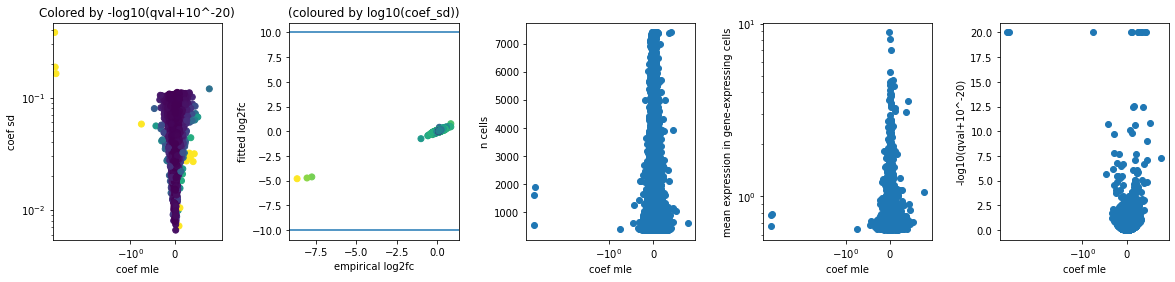

Min coef_sd: 0.006601147062899557


In [24]:
# Plot 5 different diagramms for, coef sd over coef mle,  fitted log2fc over empirical log3fc, n cells over coef mle,  mean expr in gene_epxr cells over coef mle,  -log10(qval+10^-20) over coef mle,
# to see if the filtering was successfull and we can advance 

fig,ax=plt.subplots(1,5,figsize=(20,4))
plt.subplots_adjust(wspace=0.4)

ax[0].scatter(summary.coef_mle,summary.coef_sd,c=-np.log10(summary.qval+10**-20))
ax[0].set_xlabel('coef mle')
ax[0].set_ylabel('coef sd')
ax[0].set_yscale('log')
ax[0].set_xscale('symlog')
ax[0].set_title('Colored by -log10(qval+10^-20)')

ax[4].scatter(summary.coef_mle,-np.log10(summary.qval+10**(-20)))
ax[4].set_xlabel('coef mle')
ax[4].set_ylabel('-log10(qval+10^-20)')
ax[4].set_xscale('symlog')

if 'empirical_log2fc' in dir(result):
    ax[1].set_title('(coloured by log10(coef_sd))')
    # genes with nan empirical lfc will not be shown
    ax[1].scatter(x=result.empirical_log2fc.values,y=summary.log2fc,
                c=np.log10(summary.coef_sd))
    ax[1].set_xlabel('empirical log2fc')
    ax[1].set_ylabel('fitted log2fc')
    #ax[1].set_yscale('symlog')
    ax[1].axhline(10)
    ax[1].axhline(-10)

ax[2].scatter(summary.coef_mle,n_cells[summary.gene])
ax[2].set_xlabel('coef mle')
ax[2].set_ylabel('n cells')
ax[2].set_xscale('symlog')

ax[3].scatter(summary.coef_mle,mean_expr_in_expr_cells[summary.gene])
ax[3].set_xlabel('coef mle')
ax[3].set_ylabel('mean expression in gene-expressing cells')
ax[3].set_xscale('symlog')
ax[3].set_yscale('log')

display(fig)
plt.close()
print('Min coef_sd:',summary.coef_sd.min())

Add gene symbols as index

In [25]:
# give summary an index with the gene_symbols
summary['EID']=summary.index
summary.index=adata_b_rn_sub.var.loc[summary.index,'gene_symbol']

In [26]:
# Save summary table for sharing
if True:
    summary.to_csv(
        path_de+'maleFemale_Fltp_P16_'+str(min_cells_ratio)+'_summary_sdFiltered.tsv',
    sep='\t',index=False)

## Check top genes

In [ ]:
# The top/bottom DE genes
nAnz = 10
# Get the top 10 Genes, and save then in summary_abs_top10
summary_abs_topnAnz = summary.coef_mle.sort_values(ascending=False)[0:nAnz]
# Get the bottom 10 Genes, and save then in summary_abs_bottom10
summary_abs_bottomnAnz = summary.coef_mle.sort_values(ascending=True)[0:nAnz]

# Get the Top/bottom 10 Genes in a list
genes_top = summary_abs_topnAnz.index.tolist()
genes_bottom = summary_abs_bottomnAnz.index.tolist()

In [30]:
# Print out the top DE genes 
summary.loc[genes_top,:]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll,EID
gene_symbol,,,,,,,,,,,
Snhg11,ENSMUSG00000044349,1.429581e-10,4.930995e-08,0.766986,0.236241,False,1.149877e-08,0.766986,0.119604,-3131.468926,ENSMUSG00000044349
Riiad1,ENSMUSG00000028139,2.975398e-14,1.629993e-11,0.510136,0.167546,False,2.167933e-09,0.510136,0.067132,-3509.895308,ENSMUSG00000028139
Chac1,ENSMUSG00000027313,2.257359e-10,7.508136e-08,0.457356,0.235024,False,4.601959e-09,0.457356,0.072107,-4176.978626,ENSMUSG00000027313
Ogdhl,ENSMUSG00000021913,7.588565e-08,1.442292e-05,0.450710,0.098715,False,1.936270e-08,0.450710,0.083827,-2433.768459,ENSMUSG00000021913
H2bc6,ENSMUSG00000047246,2.561729e-12,1.037277e-09,0.441841,0.183502,False,3.185017e-09,0.441841,0.063121,-3721.798130,ENSMUSG00000047246
H4c9,ENSMUSG00000060639,0.000000e+00,0.000000e+00,0.431154,0.966464,False,1.259724e-08,0.431154,0.031585,-9758.139015,ENSMUSG00000060639
Ppy,ENSMUSG00000017316,0.000000e+00,0.000000e+00,0.406000,89.187559,False,2.130383e-07,0.406000,0.026901,-39418.321827,ENSMUSG00000017316
Mlf1,ENSMUSG00000048416,8.189089e-06,9.188553e-04,0.391024,0.115889,False,7.115542e-10,0.391024,0.087670,-2657.630290,ENSMUSG00000048416
Tesc,ENSMUSG00000029359,1.287200e-04,8.750142e-03,0.387101,0.068154,False,3.383651e-10,0.387101,0.101100,-1840.954933,ENSMUSG00000029359


In [33]:
# Print out the bottom DE genes 
summary.loc[genes_bottom,:]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll,EID
gene_symbol,,,,,,,,,,,
Uty,ENSMUSG00000068457,0.000000e+00,0.000000e+00,-4.798545,0.079243,False,1.926195e-04,-4.798545,0.380271,-1598.575915,ENSMUSG00000068457
Ddx3y,ENSMUSG00000069045,0.000000e+00,0.000000e+00,-4.724499,0.304936,False,7.274571e-02,-4.724499,0.186953,-390.746368,ENSMUSG00000069045
Eif2s3y,ENSMUSG00000069049,0.000000e+00,0.000000e+00,-4.616342,0.360920,False,1.096880e-03,-4.616342,0.163390,-3724.829833,ENSMUSG00000069049
Isoc2a,ENSMUSG00000086784,0.000000e+00,0.000000e+00,-0.748663,0.059229,False,2.573457e-01,-0.748663,0.058087,-1831.839838,ENSMUSG00000086784
4930481A15Rik,ENSMUSG00000086938,8.420491e-09,1.960501e-06,-0.459828,0.094794,False,6.516619e-09,-0.459828,0.079834,-2352.965227,ENSMUSG00000086938
H2ac20,ENSMUSG00000068855,3.219647e-14,1.665809e-11,-0.424520,0.204192,False,1.803670e-08,-0.424520,0.055936,-3974.186020,ENSMUSG00000068855
Slc18a1,ENSMUSG00000036330,3.958403e-04,2.071046e-02,-0.338605,0.064368,False,2.885033e-10,-0.338605,0.095574,-1765.367028,ENSMUSG00000036330
3222401L13Rik,ENSMUSG00000073590,1.829808e-03,5.680334e-02,-0.326626,0.061528,False,4.858308e-09,-0.326626,0.104804,-1706.986565,ENSMUSG00000073590
Prss23,ENSMUSG00000039405,1.055264e-04,7.445211e-03,-0.314930,0.107505,False,3.462219e-09,-0.314930,0.081219,-2562.208720,ENSMUSG00000039405


### N DE genes at different filtering thresholds

In [36]:
# Try different thresholds for FDR and ALFC to see which to take:
for fdr,lfc in [(0.05,1),(0.05,0.5),(0.05,0.3),
                (0.025,1),(0.025,0.5), (0.025,0.3)]:
    print('fdr %.2e, abs(lfc) > %.1f up %i down %i'%
          (fdr,lfc,summary.query('qval<@fdr & log2fc>@lfc').shape[0],
           summary.query('qval<@fdr & log2fc<-@lfc').shape[0]))

fdr 5.00e-02, abs(lfc) > 1.0 up 0 down 3
fdr 5.00e-02, abs(lfc) > 0.5 up 2 down 4
fdr 5.00e-02, abs(lfc) > 0.3 up 19 down 9
fdr 2.50e-02, abs(lfc) > 1.0 up 0 down 3
fdr 2.50e-02, abs(lfc) > 0.5 up 2 down 4
fdr 2.50e-02, abs(lfc) > 0.3 up 19 down 9


Text(0.5, 0, 'log2fc')

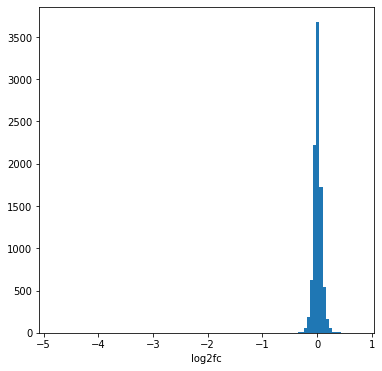

In [37]:
# Plot the distribution for log2fc
plt.hist(summary.log2fc,bins=100)
plt.xlabel('log2fc')

In [38]:
# Set the Thresholds for FDR and ALFC
FDR=0.05
ALFC=1

In [39]:
# get the up and down regulated genes 
genes_P16_up=list(summary.query('qval<@FDR & log2fc>@ALFC').sort_values('log2fc',ascending=False).gene)
genes_P16_down=list(summary.query('qval<@FDR & log2fc<-@ALFC').sort_values('log2fc').gene)

In [40]:
print('Up regulated genes: ')
print(genes_P16_up)
print('Down regulated genes: ')
print(genes_P16_down)

Up regulated genes: 
[]
Down regulated genes: 
['ENSMUSG00000068457', 'ENSMUSG00000069045', 'ENSMUSG00000069049']
